# Install Dependecies to Render OpenAI Gym Environment

In [ ]:
# # Run this asap since it takes 30 seconds.
# !pip install pyglet
# !pip install gym pyvirtualdisplay
# !pip install xvfbwrapper
# !pip install tensorflow==2.1.*
# !pip install pyvirtualdisplay
# !pip install imageio-ffmpeg

In [2]:
import gym
from gym.wrappers.record_video import RecordVideo
from gym.envs.toy_text.frozen_lake import generate_random_map
from collections import deque
from IPython.display import HTML
from IPython import display as ipythondisplay

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import io
import base64
#from pyvirtualdisplay import Display
#display = Display(visible=0, size=(1400, 900))
#display.start()

# 1.2 Build DQN Agent and Helper Functions

In [3]:
# Load gym environment and get action and state spaces.
random_map = generate_random_map(size=10, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map)
num_features = env.observation_space.n
num_actions = env.action_space.n
print('Number of state features: {}'.format(num_features))
print('Number of possible actions: {}'.format(num_actions))

Number of state features: 100
Number of possible actions: 4


In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
device = '/CPU:0'
if physical_devices:
    print("GPU found: Using GPU.")
    device = '/GPU:0'  # Use GPU
else:
    print("No GPU found: Using CPU.")

if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

No GPU found: Using CPU.


In [46]:
class DQN(tf.keras.Model):
  """Dense neural network class."""
  def __init__(self):
    super(DQN, self).__init__()
    self.dense1 = tf.keras.layers.Dense(256, activation="relu")
    self.dense2 = tf.keras.layers.Dense(256, activation="relu")
    self.dense3 = tf.keras.layers.Dense(num_actions, dtype=tf.float32) # No activation

  def call(self, x):
    """Forward pass."""
    x = tf.one_hot(x, depth=num_features)
    x = self.dense1(x)
    x = self.dense2(x)
    return self.dense3(x)

In [45]:
class ReplayBuffer(object):
  """Experience replay buffer that samples uniformly."""
  def __init__(self, size):
    self.buffer = deque(maxlen=size)

  def add(self, state, action, reward, next_state, done):
    self.buffer.append((state, action, reward, next_state, done))

  def __len__(self):
    return len(self.buffer)

  def sample(self, num_samples):
    states, actions, rewards, next_states, dones = [], [], [], [], []
    idx = np.random.choice(len(self.buffer), num_samples)
    for i in idx:
      elem = self.buffer[i]
      state, action, reward, next_state, done = elem
      states.append(np.asarray(state))
      actions.append(np.asarray(action))
      rewards.append(reward)
      next_states.append(np.asarray(next_state))
      dones.append(done)
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards, dtype=np.float32)
    next_states = np.array(next_states)
    dones = np.array(dones, dtype=np.float32)
    return states, actions, rewards, next_states, dones

In [47]:
class Agent:
    def __init__(self, ):
        self.main_nn = DQN()
        self.target_nn = DQN()

        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        self.mse = tf.keras.losses.MeanSquaredError()

    def select_epsilon_greedy_action(self, state, epsilon):
        """Take random action with probability epsilon, else take best action."""
        result = tf.random.uniform((1,))
        if result < epsilon:
          return env.action_space.sample() # Random action (left or right).
        else:
          return tf.argmax(self.main_nn(state)[0]).numpy() # Greedy action for state.

    @tf.function
    def train_step(self, states, actions, rewards, next_states, dones, discount):
        """Perform a training iteration on a batch of data sampled from the experience
        replay buffer."""
        # Calculate targets.
        next_qs = self.target_nn(next_states)
        max_next_qs = tf.reduce_max(next_qs, axis=-1)
        target = rewards + (1. - dones) * discount * max_next_qs
        with tf.GradientTape() as tape:
          qs = self.main_nn(states)
          action_masks = tf.one_hot(actions, num_actions)
          masked_qs = tf.reduce_sum(action_masks * qs, axis=-1)
          loss = self.mse(target, masked_qs)
        grads = tape.gradient(loss, self.main_nn.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.main_nn.trainable_variables))
        return loss

# 1.3 Agent Learning in Environment

In [8]:
# Hyperparameters.
num_episodes = 100000
epsilon = 1.0
epsilon_decay = 0.001
batch_size = 32
discount = 0.99
buffer = ReplayBuffer(100000)
cur_frame = 0
agent = Agent()

# Start training. Play game once and then train with a batch.
training_history = {
    'scores': [],
    'avg_scores': [],
    'epsilons': []
}
for episode in range(num_episodes+1):
  state = env.reset()
  ep_reward, done = 0, False
  while not done:
    state_in = tf.expand_dims(state, axis=0)
    action = agent.select_epsilon_greedy_action(state_in, epsilon)
    next_state, reward, done, info = env.step(action)
    ep_reward += reward
    # Save to experience replay.
    buffer.add(state, action, reward, next_state, done)
    state = next_state
    cur_frame += 1
    # Copy main_nn weights to target_nn.
    if cur_frame % 2000 == 0:
      agent.target_nn.set_weights(agent.main_nn.get_weights())

    # Train neural network.
    if len(buffer) >= batch_size:
      states, actions, rewards, next_states, dones = buffer.sample(batch_size)
      loss = agent.train_step(states, actions, rewards, next_states, dones, discount)

  if epsilon > 0.1:
    epsilon -= epsilon_decay

  # Store training history
  training_history['scores'].append(ep_reward)
  training_history['epsilons'].append(epsilon)

  # Calculate average score over last 1000 episodes
  avg_score = np.mean(training_history['scores'][-1000:])
  training_history['avg_scores'].append(avg_score)

  # Print progress
  if (episode + 1) % 1000 == 0:
      print(f"Episode: {episode + 1}/{num_episodes}")
      print(f"Score: {ep_reward:.3f}")
      print(f"Average Score (last 1000): {avg_score:.3f}")
      print(f"Epsilon: {epsilon:.3f}")
      print("-" * 40)

env.close()

Episode: 1000/100000
Score: 0.000
Average Score (last 1000): 0.000
Epsilon: 0.100
----------------------------------------
Episode: 2000/100000
Score: 0.000
Average Score (last 1000): 0.000
Epsilon: 0.100
----------------------------------------
Episode: 3000/100000
Score: 0.000
Average Score (last 1000): 0.000
Epsilon: 0.100
----------------------------------------
Episode: 4000/100000
Score: 0.000
Average Score (last 1000): 0.000
Epsilon: 0.100
----------------------------------------
Episode: 5000/100000
Score: 0.000
Average Score (last 1000): 0.000
Epsilon: 0.100
----------------------------------------
Episode: 6000/100000
Score: 0.000
Average Score (last 1000): 0.000
Epsilon: 0.100
----------------------------------------
Episode: 7000/100000
Score: 0.000
Average Score (last 1000): 0.000
Epsilon: 0.100
----------------------------------------
Episode: 8000/100000
Score: 0.000
Average Score (last 1000): 0.000
Epsilon: 0.100
----------------------------------------
Episode: 9000/10

In [49]:
def plot_learning_rewards(x, scores, epsilons):
    fig = plt.figure()
    ax = fig.add_subplot(111, label="1")
    ax2 = fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Steps", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
      running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1", label="Score")
    ax2.plot(x, running_avg, color="C1", label="Score")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.set_ticks_position('right')
    ax2.yaxis.set_label_position('right')
    ax2.set_ylabel('Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    plt.show()

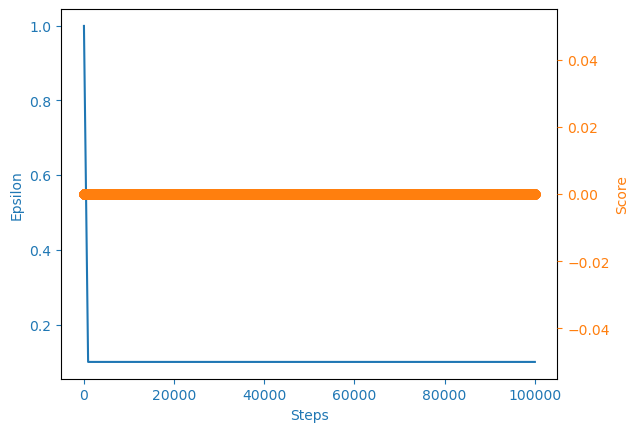

In [ ]:
steps = steps = np.arange(0, len(training_history['epsilons']), 1)
plot_learning_rewards(steps, training_history['avg_scores'], training_history['epsilons'])

### Create a $6 \times 6$ grid, smaller environment to compare

In [6]:
# Load gym environment and get action and state spaces.
random_map = generate_random_map(size=6, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map)
num_features = env.observation_space.n
num_actions = env.action_space.n
print('Number of state features: {}'.format(num_features))
print('Number of possible actions: {}'.format(num_actions))

Number of state features: 36
Number of possible actions: 4


In [ ]:
# Hyperparameters.
num_episodes = 30000
epsilon = 1.0
epsilon_decay = 0.001
batch_size = 32
discount = 0.99
buffer = ReplayBuffer(100000)
cur_frame = 0
agent = Agent()

# Start training. Play game once and then train with a batch.
training_history = {
    'scores': [],
    'avg_scores': [],
    'epsilons': []
}
for episode in range(num_episodes+1):
  state = env.reset()
  ep_reward, done = 0, False
  while not done:
    state_in = tf.expand_dims(state, axis=0)
    action = agent.select_epsilon_greedy_action(state_in, epsilon)
    next_state, reward, done, info = env.step(action)
    ep_reward += reward
    # Save to experience replay.
    buffer.add(state, action, reward, next_state, done)
    state = next_state
    cur_frame += 1
    # Copy main_nn weights to target_nn.
    if cur_frame % 2000 == 0:
      agent.target_nn.set_weights(agent.main_nn.get_weights())

    # Train neural network.
    if len(buffer) >= batch_size:
      states, actions, rewards, next_states, dones = buffer.sample(batch_size)
      loss = agent.train_step(states, actions, rewards, next_states, dones, discount)

  if epsilon > 0.1:
    epsilon -= epsilon_decay

  # Store training history
  training_history['scores'].append(ep_reward)
  training_history['epsilons'].append(epsilon)

  # Calculate average score over last 1000 episodes
  avg_score = np.mean(training_history['scores'][-1000:])
  training_history['avg_scores'].append(avg_score)

  # Print progress
  if (episode + 1) % 1000 == 0:
      print(f"Episode: {episode + 1}/{num_episodes}")
      print(f"Score: {ep_reward:.3f}")
      print(f"Average Score (last 1000): {avg_score:.3f}")
      print(f"Epsilon: {epsilon:.3f}")
      print("-" * 40)

env.close()

Episode: 1000/30000
Score: 0.000
Average Score (last 1000): 0.004
Epsilon: 0.100
----------------------------------------
Episode: 2000/30000
Score: 0.000
Average Score (last 1000): 0.006
Epsilon: 0.100
----------------------------------------
Episode: 3000/30000
Score: 0.000
Average Score (last 1000): 0.005
Epsilon: 0.100
----------------------------------------
Episode: 4000/30000
Score: 0.000
Average Score (last 1000): 0.016
Epsilon: 0.100
----------------------------------------
Episode: 5000/30000
Score: 0.000
Average Score (last 1000): 0.008
Epsilon: 0.100
----------------------------------------
Episode: 6000/30000
Score: 0.000
Average Score (last 1000): 0.004
Epsilon: 0.100
----------------------------------------
Episode: 7000/30000
Score: 0.000
Average Score (last 1000): 0.005
Epsilon: 0.100
----------------------------------------
Episode: 8000/30000
Score: 0.000
Average Score (last 1000): 0.004
Epsilon: 0.100
----------------------------------------
Episode: 9000/30000
Scor

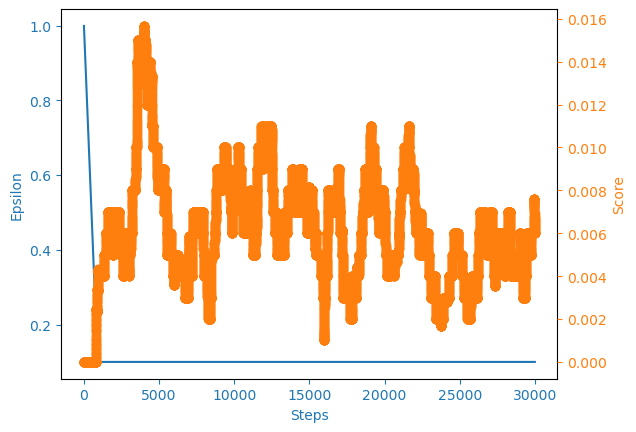

In [26]:
steps = steps = np.arange(0, len(training_history['epsilons']), 1)
plot_learning_rewards(steps, training_history['avg_scores'], training_history['epsilons'])

In [3]:
grid_size = 10
random_map = generate_random_map(size=grid_size, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map)
num_features = env.observation_space.n
num_actions = env.action_space.n
print('Number of state features: {}'.format(num_features))
print('Number of possible actions: {}'.format(num_actions))

Number of state features: 100
Number of possible actions: 4


In [4]:
def mhd_distance(state, goal):
    state_row, state_col = state // grid_size, state % grid_size
    goal_row, goal_col = goal // grid_size, goal % grid_size
    grid_max = grid_size*2

    dx = abs(state_col - goal_col)
    dy = abs(state_row - goal_row)

    distance = dx + dy
    return distance
    # return (grid_max - distance) / (grid_max * 100)

In [48]:
# Hyperparameters.
num_episodes = 10000
epsilon = 1.0
epsilon_decay = 0.001
batch_size = 32
discount = 0.99
buffer = ReplayBuffer(100000)
cur_frame = 0
agent = Agent()

# Start training. Play game once and then train with a batch.
training_history = {
    'scores': [],
    'avg_scores': [],
    'epsilons': []
}
for episode in range(num_episodes+1):
  state = env.reset()
  ep_reward, done = 0, False
  min_mhd = mhd_distance(state, num_features - 1)
  while not done:
    state_in = tf.expand_dims(state, axis=0)
    action = agent.select_epsilon_greedy_action(state_in, epsilon)
    next_state, reward, done, info = env.step(action)

    current_distance = mhd_distance(next_state, num_features - 1)
    new_reward_ = (reward - 0.01) if current_distance > min_mhd else (reward + 0.01)
    reward = max(0, new_reward_)

    ep_reward += reward
    # Save to experience replay.
    buffer.add(state, action, reward, next_state, done)
    state = next_state
    cur_frame += 1

    min_mhd = min(min_mhd, current_distance)

    # Copy main_nn weights to target_nn.
    if cur_frame % 2000 == 0:
      agent.target_nn.set_weights(agent.main_nn.get_weights())

    # Train neural network.
    if len(buffer) >= batch_size:
      states, actions, rewards, next_states, dones = buffer.sample(batch_size)
      loss = agent.train_step(states, actions, rewards, next_states, dones, discount)

  if epsilon > 0.1:
    epsilon -= epsilon_decay

  # Store training history
  training_history['scores'].append(ep_reward)
  training_history['epsilons'].append(epsilon)

  # Calculate average score over last 1000 episodes
  avg_score = np.mean(training_history['scores'][-1000:])
  training_history['avg_scores'].append(avg_score)

  # Print progress
  if (episode + 1) % 1000 == 0:
      print(f"Episode: {episode + 1}/{num_episodes}")
      print(f"Score: {ep_reward:.3f}")
      print(f"Average Score (last 1000): {avg_score:.3f}")
      print(f"Epsilon: {epsilon:.3f}")
      print("-" * 40)

env.close()

Episode: 1000/10000
Score: 0.080
Average Score (last 1000): 0.050
Epsilon: 0.100
----------------------------------------
Episode: 2000/10000
Score: 0.060
Average Score (last 1000): 0.082
Epsilon: 0.100
----------------------------------------
Episode: 3000/10000
Score: 0.120
Average Score (last 1000): 0.085
Epsilon: 0.100
----------------------------------------
Episode: 4000/10000
Score: 0.020
Average Score (last 1000): 0.086
Epsilon: 0.100
----------------------------------------
Episode: 5000/10000
Score: 0.130
Average Score (last 1000): 0.089
Epsilon: 0.100
----------------------------------------
Episode: 6000/10000
Score: 0.060
Average Score (last 1000): 0.088
Epsilon: 0.100
----------------------------------------
Episode: 7000/10000
Score: 0.040
Average Score (last 1000): 0.085
Epsilon: 0.100
----------------------------------------
Episode: 8000/10000
Score: 0.090
Average Score (last 1000): 0.085
Epsilon: 0.100
----------------------------------------
Episode: 9000/10000
Scor

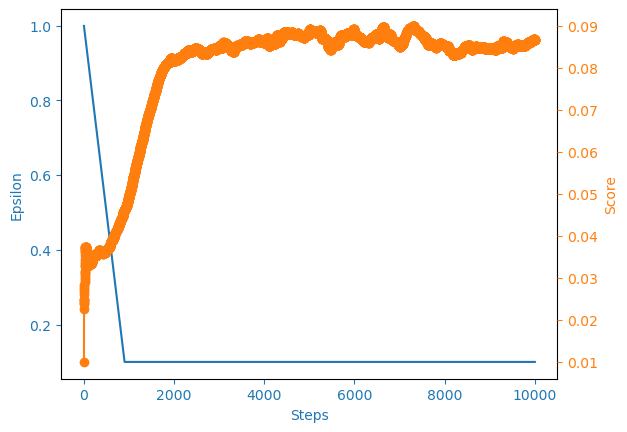

In [50]:
steps = steps = np.arange(0, len(training_history['epsilons']), 1)
plot_learning_rewards(steps, training_history['avg_scores'], training_history['epsilons'])

### Test

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class DeepQNetwork(nn.Module):
    def __init__(self, learning_rate, input_dimension, fc1_dimension, fc2_dimension,
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dimension = input_dimension #Input
        self.fc1_dimension = fc1_dimension
        self.fc2_dimension = fc2_dimension
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dimension, self.fc1_dimension)
        self.fc2 = nn.Linear(self.fc1_dimension, self.fc2_dimension)
        self.fc3 = nn.Linear(self.fc2_dimension, self.n_actions) # Ouput of actions
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.loss = nn.MSELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    #Forward propagation
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions
class Agent():
    def __init__(self, epsilon, discount_factor, learning_rate, input_dimension, batch_size,
                 n_actions, max_memory_size=100000, eps_end=0.1, eps_decay=1e-4):
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_decay = eps_decay
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate

        self.action_space = [i for i in range(n_actions)]
        self.memory_size = max_memory_size
        self.batch_size = batch_size
        self.counter = 0

        self.eval_nn = DeepQNetwork(self.learning_rate, n_actions=n_actions,
                                    input_dimension=input_dimension,
                                    fc1_dimension=256, fc2_dimension=256)
        self.current_memory = np.zeros((self.memory_size, *input_dimension), dtype = np.float32)
        self.new_memory = np.zeros((self.memory_size, *input_dimension), dtype = np.float32)
        self.action_memory = np.zeros(self.memory_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.memory_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.memory_size, dtype=bool)

    def remember(self, current_state, action, reward, new_state, done):
        index = self.counter % self.memory_size
        self.current_memory[index] = current_state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_memory[index] = new_state
        self.terminal_memory[index] = done

        self.counter += 1

    def act(self, obsv):
        if np.random.random() > self.epsilon:
            state = torch.tensor([obsv], dtype=torch.float32).to(self.eval_nn.device)
            actions = self.eval_nn.forward(state)
            action = torch.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def experience_replay(self):
        if self.counter < self.batch_size:
            return

        self.eval_nn.optimizer.zero_grad()

        max_memory = min(self.memory_size, self.counter)
        # Prevetn select same memory more than once
        batch = np.random.choice(max_memory, self.batch_size, replace=False)
        batch_idx = np.arange(self.batch_size, dtype=np.int32)
        current_state_batch = torch.tensor(self.current_memory[batch]).to(self.eval_nn.device)
        new_state_batch = torch.tensor(self.new_memory[batch]).to(self.eval_nn.device)
        reward_batch = torch.tensor(self.reward_memory[batch]).to(self.eval_nn.device)
        terminal_batch = torch.tensor(self.terminal_memory[batch]).to(self.eval_nn.device)
        action_batch = self.action_memory[batch]

        eval = self.eval_nn.forward(current_state_batch)[batch_idx, action_batch]
        next = self.eval_nn.forward(new_state_batch)
        next[terminal_batch] = 0.0

        target = reward_batch + self.discount_factor * torch.max(next, dim=1)[0]
        loss = self.eval_nn.loss(target, eval).to(self.eval_nn.device)
        loss.backward()
        self.eval_nn.optimizer.step()

        # epsilon decrementation
        if self.epsilon > self.eps_min:
            self.epsilon -= self.eps_decay
        else:
            self.epsilon = self.eps_min

In [10]:
goal = env.observation_space.n - 1
agent = Agent(epsilon=1, discount_factor=0.99, batch_size=64, n_actions=env.action_space.n,
              eps_end=0.1, input_dimension=[1,], learning_rate=0.001)
scores, eps_history = [], []
threshold = 2
for episode in range(50000):
    score = 0
    done = False
    observation = env.reset()
    min_mhd = mhd_distance(observation, goal)
    while not done:
        action = agent.act(observation)
        observation_, reward, done, info = env.step(action)

        current_distance = mhd_distance(observation_, goal)
        new_reward_ = (reward - 0.01) if current_distance > min_mhd else (reward + 0.01)
        reward = max(0, new_reward_)
        score += reward

        agent.remember(observation, action, reward, observation_, done)

        min_mhd = min(min_mhd, current_distance) + threshold
        observation = observation_
        agent.experience_replay()
    scores.append(score)
    eps_history.append(agent.epsilon)
    avg_score = np.mean(scores[-100:])
    if (episode + 1) % 500 == 0:
        print('episode ', episode, 'score %.2f' % score,
            'average score %.2f' % avg_score,
            'epsilon %.2f' % agent.epsilon)

x = [episode+1 for episode in range(len(scores))]

episode  499 score 0.02 average score 0.04 epsilon 0.82
episode  999 score 0.01 average score 0.04 epsilon 0.64
episode  1499 score 0.03 average score 0.04 epsilon 0.45
episode  1999 score 0.09 average score 0.04 epsilon 0.24
episode  2499 score 0.11 average score 0.05 epsilon 0.10
episode  2999 score 0.02 average score 0.04 epsilon 0.10
episode  3499 score 0.03 average score 0.05 epsilon 0.10
episode  3999 score 0.10 average score 0.04 epsilon 0.10
episode  4499 score 0.02 average score 0.05 epsilon 0.10
episode  4999 score 0.01 average score 0.04 epsilon 0.10
episode  5499 score 0.10 average score 0.05 epsilon 0.10
episode  5999 score 0.02 average score 0.05 epsilon 0.10
episode  6499 score 0.02 average score 0.05 epsilon 0.10
episode  6999 score 0.02 average score 0.05 epsilon 0.10
episode  7499 score 0.02 average score 0.05 epsilon 0.10
episode  7999 score 0.04 average score 0.05 epsilon 0.10
episode  8499 score 0.04 average score 0.05 epsilon 0.10
episode  8999 score 0.03 average 

KeyboardInterrupt: 

# 1.4 Create New Agent with Knowledge about the Environment

In [30]:
# Hyperparameters.
num_episodes = 1000
epsilon = 1.0
batch_size = 32
discount = 0.99
buffer = ReplayBuffer(100000)
cur_frame = 0

# Start training. Play game once and then train with a batch.
last_100_ep_rewards = []
for episode in range(num_episodes+1):
  state = env.reset()
  ep_reward, done = 0, False
  while not done:
    state_in = tf.expand_dims(state, axis=0)
    action = select_epsilon_greedy_action(state_in, epsilon)
    next_state, reward, done, info = env.step(action)
    ep_reward += reward
    # Save to experience replay.
    buffer.add(state, action, reward, next_state, done)
    state = next_state
    cur_frame += 1
    # Copy main_nn weights to target_nn.
    if cur_frame % 2000 == 0:
      target_nn.set_weights(main_nn.get_weights())

    # Train neural network.
    if len(buffer) >= batch_size:
      states, actions, rewards, next_states, dones = buffer.sample(batch_size)
      loss = train_step(states, actions, rewards, next_states, dones)

  if episode < 950:
    epsilon -= 0.001

  if len(last_100_ep_rewards) == 100:
    last_100_ep_rewards = last_100_ep_rewards[1:]
  last_100_ep_rewards.append(ep_reward)

  if episode % 50 == 0:
    print(f'Episode {episode}/{num_episodes}. Epsilon: {epsilon:.3f}. '
          f'Reward in last 100 episodes: {np.mean(last_100_ep_rewards):.3f}')
env.close()

NameError: name 'select_epsilon_greedy_action' is not defined

# Display Result of Trained DQN Agent on Cartpole Environment

In [51]:
def show_video():
  """Enables video recording of gym environment and shows it."""
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Video not found")


def wrap_env(env):
  env = RecordVideo(env, './video')
  return env

In [57]:
env = wrap_env(gym.make('FrozenLake-v1', desc=random_map))
state = env.reset()
done = False
ep_rew = 0
while not done:
  # env.render()
  env.render("rgb_array")
  state = tf.expand_dims(state, axis=0)
  action = agent.select_epsilon_greedy_action(state, epsilon=0.01)
  state, reward, done, info = env.step(action)
  ep_rew += reward
print('Episode reward was {}'.format(ep_rew))
env.close()
show_video()

Episode reward was 0.0


Reference: https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial